# Super Mario Stitching
Let's make maps of super mario worlds

In [2]:
import numpy as np
import cv2
import os

from matplotlib_helper import imshow

In [13]:
import matplotlib.pyplot as plt
%matplotlib notebook

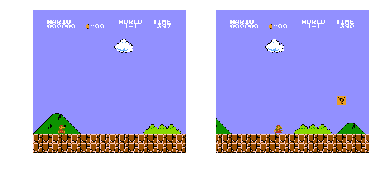

In [5]:
imageFolder = 'images'
extension = 'png'
imageFileLeft = '{}/Super Mario Bros (E)_002.{}'.format(imageFolder, extension)
imageFileRight = '{}/Super Mario Bros (E)_003.{}'.format(imageFolder, extension)

imageLeft = cv2.imread(imageFileLeft)[:,:,::-1]
imageRight = cv2.imread(imageFileRight)[:,:,::-1]

imshow(imageLeft, imageRight)

# Image Stitching
Let's try some basic homography calculation and try stitching images based on the computed homography matrix

In [128]:
def perspectiveStitch(imageLeft, imageRight):
    orb = cv2.ORB_create()
    kpLeft, desLeft = orb.detectAndCompute(imageLeft, None)
    kpRight, desRight = orb.detectAndCompute(imageRight, None)

    imageLeftKp = cv2.drawKeypoints(imageLeft, kpLeft, None, color=(0,255,0), flags=0)
    imageRightKp = cv2.drawKeypoints(imageRight, kpRight, None, color=(0,255,0), flags=0)
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(desLeft, desRight)
    
    ptsA = np.float32([kpLeft[i.queryIdx].pt for i in matches])
    ptsB = np.float32([kpRight[i.trainIdx].pt for i in matches])

    homographyMatrix, __ = cv2.findHomography(ptsB, ptsA, cv2.RANSAC, 4)    
    warpedImage = cv2.warpPerspective(imageRight, homographyMatrix, (imageLeft.shape[1]+imageRight.shape[1], imageLeft.shape[0]))
    warpedImage[:, 0:imageLeft.shape[1], :] = imageLeft
    
    w2,h2 = imageRight.shape[:2]
    imageRightTempDim = np.float32([ [0,0], [0,w2], [h2, w2], [h2,0] ]).reshape(-1,1,2)
    imageRightDim = cv2.perspectiveTransform(imageRightTempDim, homographyMatrix)
    rightEdge = int(np.min(imageRightDim[2:].T[0]))
    return warpedImage[:, :rightEdge, :]

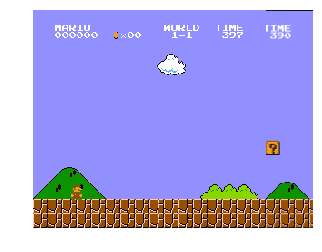

In [129]:
stitchedImage = perspectiveStitch(imageLeft, imageRight)
imshow(stitchedImage)

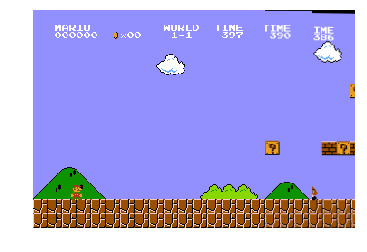

In [130]:
imageFileRight2 = '{}/Super Mario Bros (E)_004.{}'.format(imageFolder, extension)
imageRight2 = cv2.imread(imageFileRight2)[:,:,::-1]

stitchedImage2 = perspectiveStitch(stitchedImage, imageRight2)
imshow(stitchedImage2)

## Affine Stitching
We know that the game is in 2D so we won't need perspective warps

In [131]:
def affineStitch(imageLeft, imageRight):
    orb = cv2.ORB_create()
    kpLeft, desLeft = orb.detectAndCompute(imageLeft, None)
    kpRight, desRight = orb.detectAndCompute(imageRight, None)

    imageLeftKp = cv2.drawKeypoints(imageLeft, kpLeft, None, color=(0,255,0), flags=0)
    imageRightKp = cv2.drawKeypoints(imageRight, kpRight, None, color=(0,255,0), flags=0)
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(desLeft, desRight)
    
    goodMatches = []
    for m in matches:
        if m.distance < 5:
            goodMatches.append(m)
    
#     imageCorrespondence = cv2.drawMatches(imageLeft, kpLeft, imageRight, kpRight, goodMatches, None, flags=2)
#     imshow(imageCorrespondence)
    
    ptsA = np.float32([kpLeft[i.queryIdx].pt for i in goodMatches])
    ptsB = np.float32([kpRight[i.trainIdx].pt for i in goodMatches])
    
    M = cv2.getAffineTransform(ptsB[:3],ptsA[:3])
    warpedImage = cv2.warpAffine(imageRight,M,(imageLeft.shape[1]+imageRight.shape[1],imageLeft.shape[0]))
    warpedImage[:, 0:imageLeft.shape[1], :] = imageLeft
    
    homographyMatrix = np.eye(3)
    homographyMatrix[0,2] = M[0,2]
    homographyMatrix[1,2] = M[1,2]
    
    w2,h2 = imageRight.shape[:2]
    imageRightTempDim = np.float32([ [0,0], [0,w2], [h2, w2], [h2,0] ]).reshape(-1,1,2)
    imageRightDim = cv2.perspectiveTransform(imageRightTempDim, homographyMatrix)
    rightEdge = int(np.min(imageRightDim[2:].T[0]))
    return warpedImage[:, :rightEdge, :]


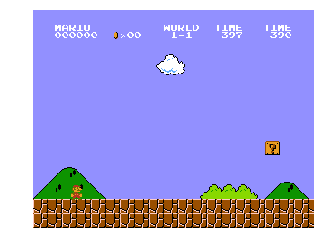

In [132]:
stitchedImage = affineStitch(imageLeft, imageRight)
imshow(stitchedImage)

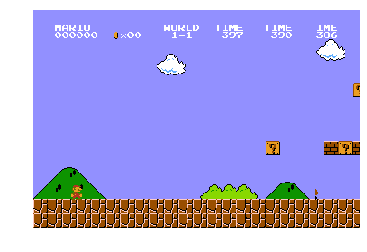

In [133]:
stitchedImage2 = affineStitch(stitchedImage, imageRight2)
imshow(stitchedImage2)

# Feature Matching
In the last section we just took the first three keypoints. Let's do it right.

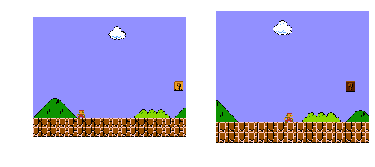

In [3]:
extension = 'png'
imageFileLeft = 'imageLeft.{}'.format(extension)
imageFileRight = 'imageRight.{}'.format(extension)

imageLeft = cv2.imread(imageFileLeft)[:,:,::-1]
imageRight = cv2.imread(imageFileRight)[:,:,::-1]

imshow(imageLeft, imageRight)

In [55]:
from scipy import stats
def affineStitch(imageLeft, imageRight):
    orb = cv2.ORB_create()
    kpLeft, desLeft = orb.detectAndCompute(imageLeft, None)
    kpRight, desRight = orb.detectAndCompute(imageRight, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(desLeft, desRight)
    
    goodMatches = []
    for m in matches:
        if kpLeft[m.queryIdx].pt[1] != kpRight[m.trainIdx].pt[1]:
            continue
        if m.distance < 10:
            goodMatches.append(m)
    
    ptsA = np.float32([kpLeft[m.queryIdx].pt for m in goodMatches])
    ptsB = np.float32([kpRight[m.trainIdx].pt for m in goodMatches])
    
    distances = np.array([kpLeft[m.queryIdx].pt[0] - kpRight[m.trainIdx].pt[0] for m in goodMatches])
    losses = np.array([np.sum(abs(distances - d)) for d in distances])
    
    # Pick three points
    # indices = np.random.randint(0, len(goodMatches), 3)
    # ptsA = np.float32([kpLeft[m.queryIdx].pt for m in goodMatches[indices]])
    # ptsB = np.float32([kpRight[m.trainIdx].pt for m in goodMatches[indices]])
    
    print(np.median(distances), np.mean(distances), stats.mode(distances).mode[0])
    print(np.argmin(losses), distances[np.argmin(losses)])
#     M = cv2.getAffineTransform(ptsB[:3],ptsA[:3])

    #     print(kpLeft[goodMatches[np.argmin(losses)].queryIdx].pt,kpRight[goodMatches[np.argmin(losses)].trainIdx].pt)
    imageCorrespondence = cv2.drawMatches(imageLeft, kpLeft, imageRight, kpRight, [goodMatches[np.argmin(losses)]], None, flags=2)
    # imageCorrespondence = cv2.drawMatches(imageLeft, kpLeft, imageRight, kpRight, goodMatches, None, flags=2)
    imshow(imageCorrespondence)

    requiredWidth = int(np.round(distances[np.argmin(losses)])) - (imageLeft.shape[1] - imageRight.shape[1])
    warpedImage = np.zeros(np.array(imageLeft.shape) + (0, requiredWidth, 0), dtype='uint8')
    print(imageLeft.shape, imageRight.shape)
    warpedImage[:, -imageRight.shape[1]:, :] = imageRight
    warpedImage[:, 0:imageLeft.shape[1], :] = imageLeft
    return warpedImage

89.0 86.16459933194247 89.57952880859375
0 89.0


<IPython.core.display.Javascript object>


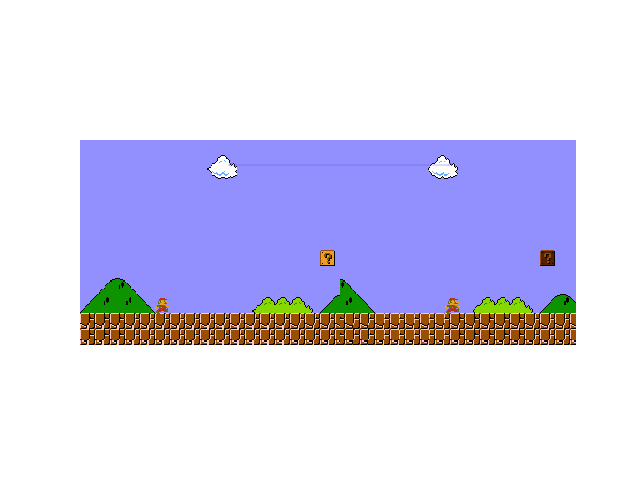

(450, 572, 3) (450, 518, 3)


<IPython.core.display.Javascript object>


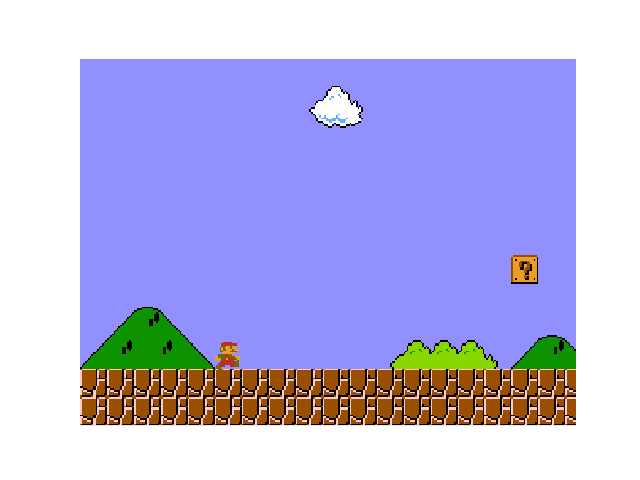

In [57]:
stitchedImage = affineStitch(imageLeft, imageRight)
imshow(stitchedImage, newFigure=True)

In [146]:
imageRight.shape

(450, 518, 3)

In [276]:
np.random.randint(0, 20, 3)

array([0, 1, 0])

In [281]:
a = np.array([1,2,3])
a[[1,2,1]]

array([2, 3, 2])

In [54]:
(imageLeft.shape[1] - imageRight.shape[1])

54